## Library Imports

In [1]:
# Cell 1
import numpy as np
import pandas as pd
import glob
import os
import logging
import tensorflow as tf
from tqdm import tqdm
from datetime import datetime
from scipy.stats import skew, kurtosis
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dense
import joblib



# Pre-processing of files 

In [5]:
# Cell 2
def load_emothaw_data(directory_path):
    all_data = []
    all_labels = []

    # Use glob to find all .svc files in the specified directory
    file_paths = glob.glob(os.path.join(directory_path, "*.svc"))
    if not file_paths:
        # Raise an error if no files are found
        raise ValueError("No files found in the specified directory")

    # Iterate over each file path found
    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        try:
            # Extract the label from the filename
            # Assuming the label is the part before the first underscore '_'
            label = int(os.path.basename(file_path).split('_')[0])

            # Load the file and strip trailing spaces
            with open(file_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]  # Ignore empty lines

            # Convert the lines into a DataFrame by splitting each line by whitespace
            df = pd.DataFrame([line.split() for line in lines])  # Split by whitespace

            # Skip empty files
            if df.empty:
                print(f"Warning: {file_path} is empty after processing. Skipping file.")
                continue

            # First row contains the total number of data rows (excluding the first row)
            total_rows = int(df.iloc[0, 0])  # Number of expected sequences

            # Extract the feature data from the subsequent rows
            data = df.iloc[1:, :].values  # All columns are treated as features

            # Check if enough data rows exist as per the first row's instruction
            if data.shape[0] < total_rows:
                raise ValueError(f"Insufficient data: expected {total_rows}, but found {data.shape[0]}")

            # Ensure each row has exactly 7 feature values
            reshaped_data = []
            for row in data:
                if len(row) == 7:
                    reshaped_data.append(row)
                else:
                    print(f"Warning: Row does not have 7 values, skipping: {row}")

            # If valid reshaped data exists, convert it into a NumPy array
            if reshaped_data:
                reshaped_data = np.array(reshaped_data, dtype=float)  # Convert to float type

                # Check that reshaped data has enough rows as expected
                if reshaped_data.shape[0] < total_rows:
                    raise ValueError(f"Insufficient data: expected {total_rows}, but found {reshaped_data.shape[0]}")

                # Append the reshaped data and labels
                all_data.append(reshaped_data)
                all_labels.append([label] * reshaped_data.shape[0])  # Append the label for each data row

                # Print the shape of reshaped data for debugging
                print(f"Shape of data from file {file_path}: {reshaped_data.shape}")

        except Exception as e:
            # If any error occurs, display the error and continue processing the next file
            print(f"Error processing file {file_path}: {e}")
            continue

    # Raise an error if no valid data was processed
    if not all_data or not all_labels:
        raise ValueError("No valid data found in the directory")

    # Print the shapes of individual data entries for debugging
    print("Shapes of all_data before concatenation:")
    for i, data_array in enumerate(all_data):
        print(f"Data array {i} shape: {data_array.shape}")

    # Concatenate all data arrays along the sample axis (rows)
    try:
        all_data = np.concatenate(all_data, axis=0)  # Concatenate data arrays
    except Exception as e:
        print(f"Error during concatenation: {e}")

    # Concatenate labels
    all_labels = np.concatenate(all_labels, axis=0)

    # Return the processed data and corresponding labels
    return all_data, all_labels

# Importing all files on the Directory
data, labels = load_emothaw_data(r'../test/test_data/')  # Directory path

Processing file: ../test/test_data\0_u00003s00001hw00001.svc
Shape of data from file ../test/test_data\0_u00003s00001hw00001.svc: (2643, 7)
Processing file: ../test/test_data\0_u00003s00001hw00002.svc
Shape of data from file ../test/test_data\0_u00003s00001hw00002.svc: (5691, 7)
Processing file: ../test/test_data\0_u00003s00001hw00003.svc
Shape of data from file ../test/test_data\0_u00003s00001hw00003.svc: (3863, 7)
Processing file: ../test/test_data\0_u00003s00001hw00004.svc
Shape of data from file ../test/test_data\0_u00003s00001hw00004.svc: (1178, 7)
Processing file: ../test/test_data\0_u00003s00001hw00005.svc
Shape of data from file ../test/test_data\0_u00003s00001hw00005.svc: (770, 7)
Processing file: ../test/test_data\0_u00003s00001hw00006.svc
Shape of data from file ../test/test_data\0_u00003s00001hw00006.svc: (4051, 7)
Processing file: ../test/test_data\0_u00003s00001hw00007.svc
Shape of data from file ../test/test_data\0_u00003s00001hw00007.svc: (3050, 7)
Processing file: ../t

## FEATURE EXTRACTION

In [6]:
# Cell 3
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

def extract_time_domain_features(data):
    logger.info("Starting time-domain feature extraction")
    start_time = datetime.now()
    
    # Vectorized computation of statistics across all samples at once
    # Compute stats for each feature across all samples
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    mins = np.min(data, axis=1)
    maxs = np.max(data, axis=1)
    percentile_25 = np.percentile(data, 25, axis=1)
    percentile_50 = np.percentile(data, 50, axis=1)
    percentile_75 = np.percentile(data, 75, axis=1)
    
    # Stack all features horizontally for each sample
    time_features = np.column_stack([
        means, stds, mins, maxs,
        percentile_25, percentile_50, percentile_75
    ])
    
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    logger.info(f"Feature extraction completed in {elapsed_time}")
    
    return time_features

def extract_frequency_domain_features(data):
    logger.info("Starting frequency-domain feature extraction")
    start_time = datetime.now()
    
    # Apply FFT to all samples at once
    freq_features = np.fft.fft(data, axis=1)
    freq_magnitude = np.abs(freq_features)
    
    # Calculate dominant frequencies and energy
    dominant_freqs = np.argmax(freq_magnitude, axis=1)
    freq_energies = np.sum(freq_magnitude, axis=1)
    
    # Combine features
    freq_features = np.column_stack([dominant_freqs, freq_energies])
    
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    logger.info(f"Frequency-domain feature extraction completed in {elapsed_time}")
    
    return freq_features

def extract_statistical_features(data):
    logger.info("Starting statistical feature extraction")
    start_time = datetime.now()
    
    # Compute statistics for all samples at once
    means = np.mean(data, axis=1)
    medians = np.median(data, axis=1)
    variances = np.var(data, axis=1)
    
    # Compute skewness and kurtosis along the feature axis
    skewness = skew(data, axis=1)
    kurtosis_vals = kurtosis(data, axis=1)
    
    # Combine all statistical features
    statistical_features = np.column_stack([
        means, medians, variances, skewness, kurtosis_vals
    ])
    
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    logger.info(f"Statistical feature extraction completed in {elapsed_time}")
    
    return statistical_features

# Example usage:
def process_features(data):
    """
    Process all features at once and combine them
    """
    time_features = extract_time_domain_features(data)
    freq_features = extract_frequency_domain_features(data)
    stat_features = extract_statistical_features(data)
    
    # Combine all features
    combined_features = np.concatenate([
        time_features,
        freq_features,
        stat_features
    ], axis=1)
    
    return combined_features

In [7]:
# Cell 4
# Extract all features
time_domain_features = extract_time_domain_features(data)
frequency_domain_features = extract_frequency_domain_features(data)
statistical_features = extract_statistical_features(data)

# Combine features
features = np.concatenate((time_domain_features, frequency_domain_features, statistical_features), axis=1)

print("Time Domain Features")
print(time_domain_features)
print("Frequency")
print(frequency_domain_features)
print("Statistical Features")
print(statistical_features)
print(time_domain_features.shape)
print(frequency_domain_features.shape)
print(statistical_features.shape)



2024-12-01 21:09:39,859 - Starting time-domain feature extraction
2024-12-01 21:09:40,495 - Feature extraction completed in 0:00:00.636009
2024-12-01 21:09:40,504 - Starting frequency-domain feature extraction
2024-12-01 21:09:40,819 - Frequency-domain feature extraction completed in 0:00:00.311160
2024-12-01 21:09:40,828 - Starting statistical feature extraction
2024-12-01 21:09:41,835 - Statistical feature extraction completed in 0:00:01.006257


Time Domain Features
[[3.25247000e+05 7.62450052e+05 1.00000000e+00 ... 3.04000000e+02
  1.87000000e+03 4.09560000e+04]
 [3.25264143e+05 7.62445522e+05 1.00000000e+00 ... 3.64500000e+02
  1.87000000e+03 4.09520000e+04]
 [3.25276571e+05 7.62443530e+05 1.00000000e+00 ... 4.02500000e+02
  1.87000000e+03 4.09535000e+04]
 ...
 [6.83118571e+04 1.50349954e+05 1.00000000e+00 ... 6.52000000e+02
  2.20000000e+03 1.95310000e+04]
 [6.82805714e+04 1.50366335e+05 1.00000000e+00 ... 5.63000000e+02
  2.20000000e+03 1.95065000e+04]
 [6.82157143e+04 1.50397191e+05 1.00000000e+00 ... 3.53500000e+02
  2.20000000e+03 1.94855000e+04]]
Frequency
[[       0.         15348978.31224078]
 [       0.         15349026.54532406]
 [       0.         15349082.72993092]
 ...
 [       0.          3053305.17900412]
 [       0.          3053350.51779034]
 [       0.          3053384.25953512]]
Statistical Features
[[3.25247000e+05 1.87000000e+03 5.81330082e+11 2.03885544e+00
  2.16142644e+00]
 [3.25264143e+05 1.87000000e

In [8]:
# Cell 5
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.regularizers import l2
@register_keras_serializable()
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.key_dense = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.value_dense = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.combine_heads = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.dropout = layers.Dropout(dropout_rate)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate,
        })
        return config

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        weights = self.dropout(weights)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

@register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadSelfAttention(embed_dim, num_heads, rate)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=l2(0.01)),
            layers.Dropout(rate),
            layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

@register_keras_serializable()
class TransformerClassifier(Model):
    def __init__(self, num_classes, embed_dim, num_heads, ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        
        # Input normalization layer
        self.input_norm = layers.BatchNormalization()
        
        # Initial dense layer with dropout
        self.dense_input = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.input_dropout = layers.Dropout(0.2)
        
        # Transformer blocks
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ]
        
        # Output layers with regularization
        self.global_average_pooling = layers.GlobalAveragePooling1D()
        self.dropout1 = layers.Dropout(0.2)
        self.dense1 = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout2 = layers.Dropout(0.2)
        self.dense2 = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    def call(self, inputs, training=False):
        x = self.input_norm(inputs)
        x = self.dense_input(x)
        x = self.input_dropout(x, training=training)
        
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)
            
        x = self.global_average_pooling(x)
        x = self.dropout1(x, training=training)
        x = self.dense1(x)
        x = self.dropout2(x, training=training)
        return self.dense2(x)

## Transformer Block

Transformer Classifier

In [9]:
# Cell 6

from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.preprocessing import StandardScaler
import joblib


# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
scaler_path = './saved_models/scaler.save'
joblib.dump(scaler, scaler_path)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Defining the model parameters
num_classes = 4
embed_dim = 32  # Increased embedding dimension
num_heads = 4    # Increased number of attention heads
ff_dim = 32    # Increased feedforward dimension
num_layers = 1   # Increased number of transformer layers

# Creating the Transformer model
model = TransformerClassifier(num_classes, embed_dim, num_heads, ff_dim, num_layers)

# Compile with modified learning rate and added metrics
model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# ModelCheckpoint callback to save the model at the end of each epoch
save_directory = './saved_models/'
os.makedirs(save_directory, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(save_directory, 'emotion_classifier_epoch_{epoch:02d}.keras'),
    save_freq='epoch',
    save_best_only=False  # Change to True if only the best model should be saved
)

# Train the model
history = model.fit(
    X_train, 
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback],
    class_weight={
        0: 1.0,  # Normal
        1: 1.0,  # Depression
        2: 1.0,  # Anxiety
        3: 1.0   # Stress
    }
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 130s 24ms/step - accuracy: 0.7159 - loss: 1.2100 - val_accuracy: 0.7746 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 2/20
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 108s 23ms/step - accuracy: 0.7728 - loss: 0.6604 - val_accuracy: 0.7984 - val_loss: 0.5848 - learning_rate: 0.0010
Epoch 3/20
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 103s 22ms/step - accuracy: 0.7812 - loss: 0.6281 - val_accuracy: 0.8154 - val_loss: 0.5430 - learning_rate: 0.0010
Epoch 4/20
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 114s 25ms/step - accuracy: 0.7839 - loss: 0.6173 - val_accuracy: 0.8375 - val_loss: 0.4696 - learning_rate: 0.0010
Epoch 5/20
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 122s 26ms/step - accuracy: 0.7828 - loss: 0.6162 - val_accuracy: 0.8357 - val_loss: 0.4625 - learning_rate: 0.0010
Epoch 6/20
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 95s 20ms/step - accuracy: 0.7816 - loss: 0.6120 - val_accuracy: 0.8419 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 7/20
4651/4651 ━━━━━━━━━━━━━━━━━━━━ 100s 22ms/step - 

5418/5418 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


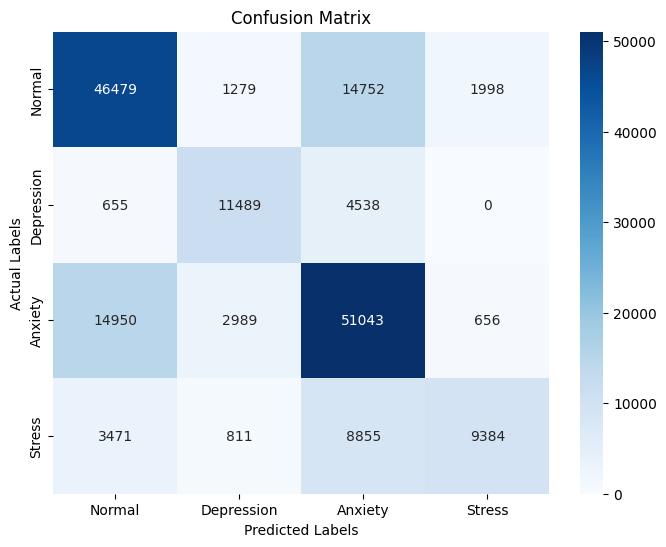

In [ ]:
# Cell 7
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred_probs = model.predict(X_test)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Step 2: Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = ['Normal','Depression', 'Anxiety', 'Stress']
# Step 3: Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


# Cell 6

from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.preprocessing import StandardScaler
import joblib


# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
scaler_path = './saved_models/scaler.save'
joblib.dump(scaler, scaler_path)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Defining the model parameters
num_classes = 4
embed_dim = 256  # Increased embedding dimension
num_heads = 8    # Increased number of attention heads
ff_dim = 256    # Increased feedforward dimension
num_layers = 1   # Increased number of transformer layers

# Creating the Transformer model
model = TransformerClassifier(num_classes, embed_dim, num_heads, ff_dim, num_layers)

# Compile with modified learning rate and added metrics
model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# ModelCheckpoint callback to save the model at the end of each epoch
save_directory = './saved_models/'
os.makedirs(save_directory, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(save_directory, 'emotion_classifier_epoch_{epoch:02d}.keras'),
    save_freq='epoch',
    save_best_only=False  # Change to True if only the best model should be saved
)

# Train the model
history = model.fit(
    X_train, 
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback],
    class_weight={
        0: 1.0,  # Normal
        1: 1.0,  # Depression
        2: 1.0,  # Anxiety
        3: 1.0   # Stress
    }
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [14]:
# Cell 8
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Print classification report with improved formatting
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)

# Convert classification report to a table
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
rows = [[cls, 
         f"{metrics['precision']:.2f}", 
         f"{metrics['recall']:.2f}", 
         f"{metrics['f1-score']:.2f}", 
         int(metrics['support'])] for cls, metrics in report.items() if cls != 'accuracy']

# Add accuracy row separately
accuracy_row = ["Accuracy", "-", "-", f"{accuracy_score(y_test, y_pred) * 100:.2f}%", "-"]
rows.append(accuracy_row)

# Print the table
print(tabulate(rows, headers, tablefmt="fancy_grid"))

# Compute and display individual scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display overall metrics in a formatted style
print("\nOverall Metrics:")
overall_metrics = [
    ["Metric", "Score"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["Precision (weighted)", f"{precision:.2f}"],
    ["Recall (weighted)", f"{recall:.2f}"],
    ["F1-Score (weighted)", f"{f1:.2f}"]
]

print(tabulate(overall_metrics, headers="firstrow", tablefmt="fancy_grid"))


Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class        │ Precision   │ Recall   │ F1-Score   │ Support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Normal       │ 0.71        │ 0.72     │ 0.71       │ 64508     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Depression   │ 0.69        │ 0.69     │ 0.69       │ 16682     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Anxiety      │ 0.64        │ 0.73     │ 0.69       │ 69638     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Stress       │ 0.78        │ 0.42     │ 0.54       │ 22521     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │ 0.71        │ 0.64     │ 0.66       │ 173349    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │ 0.69        │ 0.68     │ 0.68       │ 173349    │
├──────────────┼─────────────┼─────────

In [7]:
# New Cell 9 - Classifier using saved model
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.models import load_model

def load_and_preprocess_file(file_path):
    """
    Load and preprocess a single file for classification
    """
    try:
        # Read the file
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        # Convert to DataFrame
        df = pd.DataFrame([line.split() for line in lines])
        
        # Skip empty files
        if df.empty:
            raise ValueError(f"File is empty after processing")

        # First row contains total number of rows
        total_rows = int(df.iloc[0, 0])
        
        # Extract feature data
        data = df.iloc[1:, :].values
        
        # Ensure each row has 7 features
        reshaped_data = []
        for row in data:
            if len(row) == 7:
                reshaped_data.append(row)
        
        if not reshaped_data:
            raise ValueError("No valid data rows found")
        
        # Convert to numpy array
        reshaped_data = np.array(reshaped_data, dtype=float)
        
        # Extract features
        time_features = extract_time_domain_features(reshaped_data)
        freq_features = extract_frequency_domain_features(reshaped_data)
        stat_features = extract_statistical_features(reshaped_data)
        
        # Combine features
        combined_features = np.concatenate((time_features, freq_features, stat_features), axis=1)
        combined_features = scaler.transform(combined_features)
        return combined_features
        
    except Exception as e:
        raise Exception(f"Error processing file {file_path}: {e}")

def classify_emotion(model_path, scaler_path, file_path):
    """
    Classify emotion using saved model and scaler and return confidences for all emotions
    """
    try:
        # Load the saved model and scaler
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)
        
        # Process the input file
        features = load_and_preprocess_file(file_path, scaler)
        
        # Make prediction
        prediction = model.predict(features)
        
        # Calculate mean probabilities across all sequences
        mean_probabilities = np.mean(prediction, axis=0)
        
        # Map class indices to labels
        class_labels = ['Normal', 'Depression', 'Anxiety', 'Stress']
        
        # Create sorted list of (emotion, confidence) tuples
        emotion_confidences = [
            (label, float(prob * 100))
            for label, prob in zip(class_labels, mean_probabilities)
        ]
        # Sort by confidence in descending order
        emotion_confidences.sort(key=lambda x: x[1], reverse=True)
        
        # The predicted emotion is the first one (highest confidence)
        predicted_emotion = emotion_confidences[0][0]
        
        return predicted_emotion, emotion_confidences
        
    except Exception as e:
        raise Exception(f"Classification error: {e}")

def classify_directory(model_path, scaler_path, directory_path):
    """
    Classify all .svc files in a directory
    """
    results = []
    
    # Find all .svc files
    file_paths = glob.glob(os.path.join(directory_path, "*.svc"))
    
    if not file_paths:
        raise ValueError("No .svc files found in the directory")
    
    for file_path in file_paths:
        try:
            predicted_emotion, emotion_confidences = classify_emotion(
                model_path, scaler_path, file_path
            )
            results.append({
                'file': os.path.basename(file_path),
                'predicted_emotion': predicted_emotion,
                'confidences': emotion_confidences
            })
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return results

# Example usage:
if __name__ == "__main__":
    # Path to your saved model
    model_path = '../trainmodel/Original Only.keras'
    scaler_path = '../trainmodel/Original Only.save'
    # Example 1: Classify a single file
    # try:
    #     file_path = './input_files/u00075s00001_hw00002.svc'
    #     emotion, confidence = classify_emotion(model_path, file_path)
    #     print(f"\nFile: {os.path.basename(file_path)}")
    #     print(f"Predicted Emotion: {emotion}")
    #     print(f"Confidence: {confidence:.2f}%")
    # except Exception as e:
    #     print(f"Error classifying single file: {e}")
    
    # Example 2: Classify all files in a directory
    try:
        directory_path = '../test/destination_undersampling/'
        # directory_path = '../test/label copy/'
        results = classify_directory(model_path, scaler_path, directory_path)
        
        print("\nDirectory Classification Results:")
        print("================================")
        for result in results:
            print(f"\nFile: {result['file']}")
            print(f"Predicted Emotion: {result['predicted_emotion']}")
            print(f"Confidence: {result['confidence']:.2f}%")
    except Exception as e:
        print(f"Error classifying directory: {e}")



2024-12-01 11:51:03,226 - From C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\core.py:204: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Error processing ../test/destination_undersampling\0_u00037s00001hw00001.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00037s00001hw00002.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00037s00001hw00003.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00037s00001hw00004.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00037s00001hw00005.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00037s00001hw00006.svc: Classification error: load_and_preprocess_file() takes 1 posit

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\serialization_lib.py:730: UserWarning: Model 'transformer_classifier_6' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Error processing ../test/destination_undersampling\0_u00039s00001hw00005.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00039s00001hw00006.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00039s00001hw00007.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00040s00001hw00001.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00040s00001hw00002.svc: Classification error: load_and_preprocess_file() takes 1 positional argument but 2 were given
Error processing ../test/destination_undersampling\0_u00040s00001hw00003.svc: Classification error: load_and_preprocess_file() takes 1 posit

In [9]:
# Cell 4 - Define preprocessing and classification functions
def load_and_preprocess_file(file_path, scaler):
    """
    Load and preprocess a single file for classification
    """
    try:
        # Read the file
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        # Convert to DataFrame
        df = pd.DataFrame([line.split() for line in lines])
        
        if df.empty:
            raise ValueError(f"File is empty after processing")

        # First row contains total number of rows
        total_rows = int(df.iloc[0, 0])
        
        # Extract feature data
        data = df.iloc[1:, :].values
        
        # Ensure each row has 7 features
        reshaped_data = []
        for row in data:
            if len(row) == 7:
                reshaped_data.append(row)
        
        if not reshaped_data:
            raise ValueError("No valid data rows found")
        
        # Convert to numpy array
        reshaped_data = np.array(reshaped_data, dtype=float)
        
        # Extract features
        time_features = extract_time_domain_features(reshaped_data)
        freq_features = extract_frequency_domain_features(reshaped_data)
        stat_features = extract_statistical_features(reshaped_data)
        
        # Combine features
        combined_features = np.concatenate((time_features, freq_features, stat_features), axis=1)
        combined_features = scaler.transform(combined_features)
        return combined_features
        
    except Exception as e:
        raise Exception(f"Error processing file {file_path}: {e}")

def classify_emotion(model_path, scaler_path, file_path, results_file):
    """
    Classify emotion using saved model and scaler with detailed logging
    """
    try:
        # Load the saved model and scaler
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)
        
        # Get filename
        filename = os.path.basename(file_path)
        
        # Process the input file
        features = load_and_preprocess_file(file_path, scaler)
        
        # Make prediction
        prediction = model.predict(features)
        
        # Calculate mean probabilities across all sequences
        mean_probabilities = np.mean(prediction, axis=0)
        
        # Map class indices to labels
        class_labels = ['Normal', 'Depression', 'Anxiety', 'Stress']
        
        # Create sorted list of (emotion, confidence) tuples
        emotion_confidences = sorted(
            [(label, float(prob * 100)) for label, prob in zip(class_labels, mean_probabilities)], 
            key=lambda x: x[1], 
            reverse=True
        )
        
        # Prepare results string
        results_str = f"{filename}: Overall Prediction - {emotion_confidences[0][0]} | Confidence Levels: " + \
                      ", ".join([f"{emotion}: {conf:.2f}%" for emotion, conf in emotion_confidences])
        
        # Print results
        print(results_str)
        
        # Append results to file
        with open(results_file, 'a') as f:
            f.write(results_str + '\n')
        
        return emotion_confidences[0][0], emotion_confidences
        
    except Exception as e:
        error_msg = f"Error processing {filename}: {e}"
        print(error_msg)
        
        # Log errors to file
        with open(results_file, 'a') as f:
            f.write(error_msg + '\n')
        
        raise


# Cell 6 - Import additional library for exporting to Excel
import xlsxwriter

# Update the classify_directory function to include label verification and export to Excel
def classify_directory_with_labels(model_path, scaler_path, directory_path, output_excel, results_txt):
    """
    Classify all .svc files in a directory, verify classifications against labels in filenames,
    and export results to Excel and txt
    """
    # Clear existing results file
    open(results_txt, 'w').close()
    
    results = []
    label_map = {'0': 'Normal', '1': 'Depression', '2': 'Anxiety', '3': 'Stress'}
    
    # Find all .svc files
    file_paths = glob.glob(os.path.join(directory_path, "*.svc"))
    
    if not file_paths:
        raise ValueError("No .svc files found in the directory")
    
    for file_path in file_paths:
        try:
            # Extract true label from filename
            filename = os.path.basename(file_path)
            label_key = filename[0]
            true_label = label_map.get(label_key)
            
            # Classify the file
            predicted_emotion, emotion_confidences = classify_emotion(
                model_path, scaler_path, file_path, results_txt
            )
            
            # Check if the prediction is correct
            is_correct = predicted_emotion == true_label
            
            # Store the result if classification was correct
            if is_correct:
                confidence = next(conf[1] for conf in emotion_confidences if conf[0] == predicted_emotion)
                results.append({
                    'file': filename,
                    'true_label': true_label,
                    'predicted_emotion': predicted_emotion,
                    'confidence': confidence
                })
                
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Convert results to a DataFrame and export to Excel
    df_results = pd.DataFrame(results)
    with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
        df_results.to_excel(writer, sheet_name='Correct Classifications', index=False)
    
    print(f"Results saved to {output_excel} and {results_txt}")

# Cell 7 - Run the classifier with directory and export results
# Set the paths
model_path = '../trainmodel/Original-with-synthetic.keras'
scaler_path = '../trainmodel/Original-with-synthetic.save'
input_directory = '../test/destination_undersampling/'
output_excel = './classification_results.xlsx'
results_txt = './classification_results.txt'

try:
    # Classify files and export correct classifications to Excel and txt
    classify_directory_with_labels(model_path, scaler_path, input_directory, output_excel, results_txt)
except Exception as e:
    print(f"Error during classification: {e}")

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2024-12-01 12:03:19,571 - Starting time-domain feature extraction
2024-12-01 12:03:19,580 - Feature extraction completed in 0:00:00.005001
2024-12-01 12:03:19,583 - Starting frequency-domain feature extraction
2024-12-01 12:03:19,587 - Frequency-domain feature extraction completed in 0:00:00.002002
2024-12-01 12:03:19,589 - Starting statistical feature extraction
2024-12-01 12:03:19,589 - Statistical feature extraction completed in 0:00:00


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
0_u00037s00001hw00001.svc: Prediction - Anxiety | Confidence: 77.24%


C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2024-12-01 12:03:23,553 - Starting time-domain feature extraction
2024-12-01 12:03:23,555 - Feature extraction completed in 0:00:00.000408
2024-12-01 12:03:23,555 - Starting frequency-domain feature extraction
2024-12-01 12:03:23,555 - Frequency-domain feature extraction completed in 0:00:00
2024-12-01 12:03:23,555 - Starting statistical feature extraction
2024-12-01 12:03:23,575 - Statistical feature extraction completed in 0:00:00.019816


103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
0_u00037s00001hw00002.svc: Prediction - Depression | Confidence: 62.81%


C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2024-12-01 12:03:28,013 - Starting time-domain feature extraction
2024-12-01 12:03:28,019 - Feature extraction completed in 0:00:00.005697
2024-12-01 12:03:28,021 - Starting frequency-domain feature extraction
2024-12-01 12:03:28,024 - Frequency-domain feature extraction completed in 0:00:00.002003
2024-12-01 12:03:28,025 - Starting statistical feature extraction
2024-12-01 12:03:28,039 - Statistical feature extraction completed in 0:00:00.011739


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
0_u00037s00001hw00003.svc: Prediction - Depression | Confidence: 62.05%


KeyboardInterrupt: 

# END
